# Transfer Learning with MobileNetV2

Bem-vindo à tarefa desta semana, na qual você usará aprendizado de transferência em uma CNN pré-treinada para construir um classificador Alpaca/Not Alpaca!

<img src="images/alpaca.png" style="width:300px;height:220px;">

Um modelo pré-treinado é uma rede que já foi treinada em um grande conjunto de dados e salva, o que permite usá-la para personalizar seu próprio modelo de forma econômica e eficiente. O que você usará, MobileNetV2, foi projetado para fornecer desempenho rápido e computacionalmente eficiente. Ele foi pré-treinado no ImageNet, um conjunto de dados contendo mais de 14 milhões de imagens e 1.000 classes.

Ao final desta tarefa, você será capaz de:

- Criar um conjunto de dados a partir de um diretório
- Pré-processar e aumentar dados usando a API sequencial
- Adapte um modelo pré-treinado a novos dados e treine um classificador usando a API Funcional e MobileNet
- Ajuste as camadas finais de um classificador para melhorar a precisão

## Nota importante sobre envio para o AutoGrader

Antes de enviar sua tarefa para o AutoGrader, verifique se você não está fazendo o seguinte:

1. Você não adicionou nenhum comando `print` _extra_ na atribuição.
2. Você não adicionou nenhuma célula de código _extra_ na atribuição.
3. Você não alterou nenhum dos parâmetros da função.
4. Você não está usando nenhuma variável global em seus exercícios classificados. A menos que seja especificamente instruído a fazê-lo, evite-o e use as variáveis locais.
5. Você não está alterando o código de atribuição onde não é necessário, como criar variáveis _extra_.

Se você fizer qualquer um dos itens a seguir, receberá algo como "Erro do avaliador: feedback do avaliador não encontrado" (ou erro similarmente inesperado) ao enviar sua tarefa. Antes de pedir ajuda/depurar os erros em sua tarefa, verifique-os primeiro. Se esse for o caso e você não se lembrar das alterações feitas, poderá obter uma nova cópia da tarefa seguindo estas [instruções](https://www.coursera.org/learn/convolutional-neural- redes/suplemento/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Exercise 1 - data_augmenter](#ex-1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 2 - alpaca_model](#ex-2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [Exercise 3](#ex-3)

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1-1'></a>
### 1.1 Criar o conjunto de dados e dividi-lo em conjuntos de treinamento e validação

Ao treinar e avaliar modelos de aprendizado profundo no Keras, gerar um conjunto de dados a partir de arquivos de imagem armazenados em disco é simples e rápido. Chame `image_data_set_from_directory()` para ler o diretório e criar conjuntos de dados de treinamento e validação.

Se estiver especificando uma divisão de validação, você também precisará especificar o subconjunto para cada parte. Basta definir o conjunto de treinamento como `subset='training'` e o conjunto de validação como `subset='validation'`.

Você também definirá suas sementes para corresponder umas às outras, para que seus conjuntos de treinamento e validação não se sobreponham. :)

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "datasets/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Agora vamos dar uma olhada em algumas das imagens do conjunto de treinamento:

**Observação:** o conjunto de dados original também contém algumas imagens incorretas.

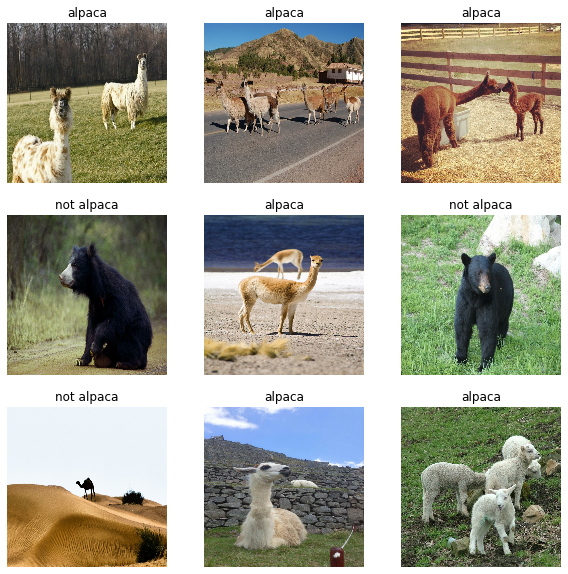

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Pré-processar e aumentar dados de treinamento

Você pode ter encontrado `dataset.prefetch` em uma atribuição anterior do TensorFlow, como uma importante etapa extra no pré-processamento de dados.

O uso de `prefetch()` evita um gargalo de memória que pode ocorrer durante a leitura do disco. Ele separa alguns dados e os mantém prontos para quando forem necessários, criando um conjunto de dados de origem a partir de seus dados de entrada, aplicando uma transformação para pré-processá-los e, em seguida, iterando sobre o conjunto de dados um elemento por vez. Como a iteração é streaming, os dados não precisam caber na memória.

Você pode definir o número de elementos para pré-busca manualmente ou pode usar `tf.data.experimental.AUTOTUNE` para escolher os parâmetros automaticamente. Autotune solicita `tf.data` para ajustar esse valor dinamicamente no tempo de execução, rastreando o tempo gasto em cada operação e alimentando esses tempos em um algoritmo de otimização. O algoritmo de otimização tenta encontrar a melhor alocação de seu orçamento de CPU em todas as operações ajustáveis.

Para aumentar a diversidade no conjunto de treinamento e ajudar seu modelo a aprender melhor os dados, é uma prática padrão aumentar as imagens transformando-as, ou seja, invertendo-as e girando-as aleatoriamente. A API sequencial da Keras oferece um método direto para esses tipos de aumentos de dados, com camadas de pré-processamento personalizáveis integradas. Essas camadas são salvas com o restante do seu modelo e podem ser reutilizadas posteriormente. Ah, tão conveniente!

Como sempre, você está convidado a ler os documentos oficiais, que você pode encontrar para aumentar os dados [aqui](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Exercício 1 - data_augmenter

Implemente uma função para aumento de dados. Use um modelo de keras `Sequencial` composto por 2 camadas:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [5]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential() # Cria um objeto 'Sequential' para definir a sequencia de camadas
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [6]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')

All tests passed!


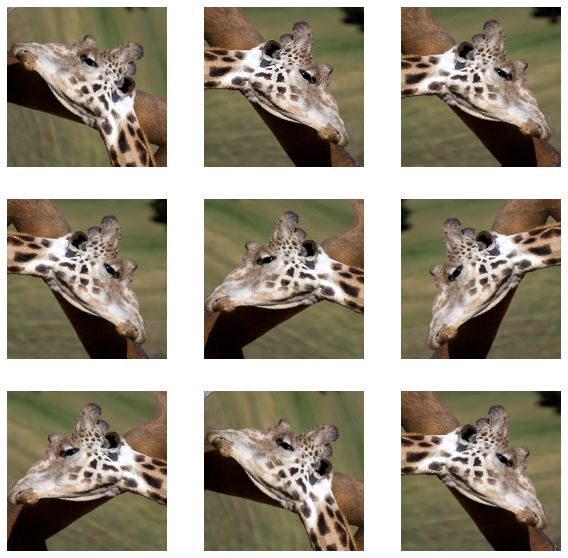

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')